In [104]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.optimizers import *
from keras.applications import *
from keras.applications import imagenet_utils
from keras.preprocessing.image import *
from keras.utils import multi_gpu_model

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from glob import glob
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import *
from sklearn.utils import shuffle

import multiprocessing
from multiprocessing.dummy import Pool
from pprint import pprint

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
n_gpus = len(os.environ['CUDA_VISIBLE_DEVICES'].split(','))

In [2]:
batch_size = 4 * n_gpus
model_name = ''
preprocess_func = inception_resnet_v2.preprocess_input
MODEL = InceptionResNetV2

f = 2
width = int(2560 / f)
height = int(1920 / f)
classes = ['正常', '吊经', '擦洞', '跳花', '毛洞', '织稀', '扎洞', '缺经', '毛斑', '其他']
n_classes = len(classes)

In [3]:
idg = ImageDataGenerator(horizontal_flip=True,
                         rotation_range=15,
                         zoom_range=0.2)
idg2 = ImageDataGenerator()

gen_train = idg.flow_from_directory('train', target_size=(height, width), 
                                    interpolation='lanczos', classes=classes, batch_size=batch_size)
gen_valid = idg2.flow_from_directory('valid', target_size=(height, width), shuffle=False, 
                                     interpolation='lanczos', classes=classes, batch_size=batch_size)
y_valid = (gen_valid.classes != 0).astype(int)

Found 1816 images belonging to 10 classes.
Found 203 images belonging to 10 classes.


In [4]:
a = [(x[x.rfind('-')+1:x.rfind('.')], x) for x in glob('models/*.h5')]
sorted(a, key=lambda x:x[0], reverse=True)[:50]

[('0.962335', 'models/irv2_0731-0.001001-120-0.962335.h5'),
 ('0.954225', 'models/irv2_0801-0.000100-60-0.954225.h5')]

In [5]:
base_model = MODEL(include_top=False, weights='imagenet')
input_tensor = Input((height, width, 3))
x = Lambda(preprocess_func)(input_tensor)
x = base_model(x)
x = GlobalAvgPool2D()(x)
x = Dense(n_classes, activation='softmax')(x)
model = Model(input_tensor, x)

In [6]:
fname_model = 'models/irv2_0731-0.001001-120-0.962335.h5'
model.load_weights(fname_model)

In [8]:
y_pred = model.predict_generator(gen_valid, verbose=1, workers=multiprocessing.cpu_count())

13/13 [==============================] - 25s 2s/step
0.9623346137430645
0.9211822660098522
array([[129,   3],
       [ 13,  58]])


In [105]:
y_pred, y_valid = shuffle(y_pred, y_valid)

y_pred2 = 1 - y_pred[:,0]
y_pred3 = 1 - (np.argmax(y_pred, axis=-1) == 0)
pprint(roc_auc_score(y_valid, y_pred2))
pprint(accuracy_score(y_valid, y_pred3))
pprint(confusion_matrix(y_valid > 0.5, y_pred3))

0.9623346137430645
0.9211822660098522
array([[129,   3],
       [ 13,  58]])


In [106]:
y_pred4 = np.round(y_pred2, 6).clip(1e-6, 1-1e-6)

In [107]:
pprint(roc_auc_score(y_valid, y_pred4))

0.9623346137430645


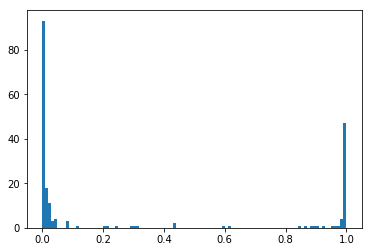

In [108]:
plt.hist(y_pred4, bins=100);

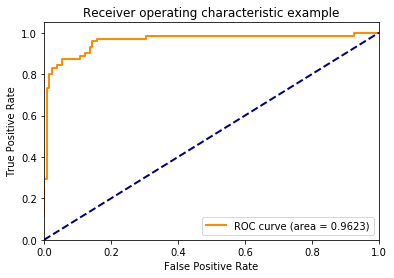

In [109]:
y_test = y_valid
y_score = y_pred4

fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()